# Observed teleconnection heterogeneity in space and time
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import signal, stats

Data location

In [2]:
loc_in = "../Data/Teleconnections/"
loc_shp = "../Data/ProcessedCountryShapefile/"
loc_pop = "../Data/GPW/"

Shapefile

In [3]:
shp = gp.read_file(loc_shp)
iso_shp = shp.ISO3.values
isonums = {i: k for i, k in enumerate(shp.ISO3)}
isonums_rev = {k: i for i, k in enumerate(shp.ISO3)}
shapes = [(shape, n) for n, shape in enumerate(shp.geometry)]

Shapefile averaging functions

In [4]:
def transform_from_latlon(lat, lon):
    # Written by Alex Gottlieb
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale
def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xarray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))
def flip_lon_tll(da):
    # flip 360 to 180 lon
    # for time-lat-lon xarray dataarray

    # get coords
    lat_da = da.coords["lat"]
    lon_da = da.coords["lon"]
    time_da = da.coords["time"]

    # flip lon
    lon_180 = (lon_da.values + 180) % 360 - 180

    # new data array
    da_180 = xr.DataArray(da.values,
                          coords=[time_da,lat_da.values,lon_180],
                          dims=["time","lat","lon"])

    # flip dataarray so it goes from -180 to 180 
    # (instead of 0-180, -180-0)
    lon_min_neg = np.amin(lon_180[lon_180<0])
    lon_max_neg = np.amax(lon_180[lon_180<0])
    lon_min_pos = np.amin(lon_180[lon_180>=0])
    lon_max_pos = np.amax(lon_180[lon_180>=0])
    da_180_flip = xr.concat([da_180.loc[:,:,lon_min_neg:lon_max_neg],
                             da_180.loc[:,:,lon_min_pos:lon_max_pos]],
                            dim="lon")
    return(da_180_flip)

def flip_lon_ll(da):
    # flip 360 to 180 lon
    # for lat-lon xarray dataarray

    # get coords
    lat_da = da.coords["lat"]
    lon_da = da.coords["lon"]

    # flip lon
    lon_180 = (lon_da.values + 180) % 360 - 180

    # new data array
    da_180 = xr.DataArray(da.values,
                          coords=[lat_da,lon_180],
                          dims=["lat","lon"])

    # flip dataarray so it goes from -180 to 180 
    # (instead of 0-180, -180-0)
    lon_min_neg = np.amin(lon_180[lon_180<0])
    lon_max_neg = np.amax(lon_180[lon_180<0])
    lon_min_pos = np.amin(lon_180[lon_180>=0])
    lon_max_pos = np.amax(lon_180[lon_180>=0])
    da_180_flip = xr.concat([da_180.loc[:,lon_min_neg:lon_max_neg],
                             da_180.loc[:,lon_min_pos:lon_max_pos]],
                            dim="lon")
    return(da_180_flip)

def xr_country_average(data,shapes,iso_list,isonums_dict):
    country_array = xr.DataArray(np.full((len(iso_list)),np.nan),
                                 coords=[iso_list],dims=["iso"])
    
    isoraster = rasterize(shapes,data.coords)
    data.coords["country"] = isoraster
    countrymean = data.groupby("country").mean()
    
    isocoord = np.array([isonums_dict[n] for n in countrymean.coords["country"].values])
    country_array.loc[isocoord] = countrymean.values
    return(country_array)
def xr_country_average_weighted(data,shapes,iso_list,isonums_dict,weight=False,weightdata=None):
    country_array = xr.DataArray(np.full((len(iso_list)),np.nan),
                                 coords=[iso_list],dims=["iso"])
    
    isoraster = rasterize(shapes,data.coords)
    data.coords["country"] = isoraster
    if weight:
        weightdata.coords["country"] = isoraster
        countrymean = ((data * weightdata).groupby("country").sum())/(weightdata.groupby("country").sum())
    else:
        countrymean = data.groupby("country").mean()
    
    isocoord = np.array([isonums_dict[n] for n in countrymean.coords["country"].values])
    country_array.loc[isocoord] = countrymean.values
    return(country_array)
def xr_country_std(data,shapes,iso_list,isonums_dict):
    country_array = xr.DataArray(np.full((len(iso_list)),np.nan),
                                 coords=[iso_list],dims=["iso"])
    
    isoraster = rasterize(shapes,data.coords)
    data.coords["country"] = isoraster
    countrystd = data.groupby("country").std()
    
    isocoord = np.array([isonums_dict[n] for n in countrystd.coords["country"].values])
    country_array.loc[isocoord] = countrystd.values
    return(country_array)

#### Analysis

Read population

In [5]:
# one degree
pop_onedegree = (xr.open_dataset(loc_pop+"1Degree/gpw_v4_population_count_1degree_lonflip.nc").data_vars["population"])[0,::-1,:]
pop_flip_onedegree = flip_lon_ll(pop_onedegree.rename({"latitude":"lat","longitude":"lon"}))
lat_min_onedegree = np.amin(pop_flip_onedegree.lat.values)
lat_max_onedegree = np.amax(pop_flip_onedegree.lat.values)

Read original obs teleconnections

In [6]:
y1_tc = 1960
y2_tc = 2019

In [7]:
tc_orig = xr.open_dataset(loc_in+"ENSO_observed_teleconnections_DJF_"+str(y1_tc)+"-"+str(y2_tc)+".nc").data_vars["combined_corr_e_running"]

In [8]:
tc_orig2 = xr.open_dataset(loc_in+"ENSO_observed_teleconnections_DJF_"+str(y1_tc)+"-"+str(y2_tc)+".nc").data_vars["combined_reg_e_running"]

Now teleconnections in running windows

In [9]:
tc_windows = xr.open_dataset(loc_in+"ENSO_observed_teleconnections_running_windows_DJF_"+str(y1_tc)+"-"+str(y2_tc)+".nc").data_vars["t_p_corr_running_e"]

In [10]:
tc_window_cv = tc_windows.std(dim="window")/tc_windows.mean(dim="window")

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Now gridded teleconnections

In [11]:
tc_gridded = xr.open_dataset(loc_in+"ENSO_gridded_teleconnections_DJF_"+str(y1_tc)+"-"+str(y2_tc)+".nc").data_vars["t_p_corr_e"]
p_gridded = xr.open_dataset(loc_in+"ENSO_gridded_teleconnections_DJF_"+str(y1_tc)+"-"+str(y2_tc)+".nc").data_vars["p_corr2_e"]

Calculate coefficients of variation and plot

In [12]:
tc_gridded_flip = flip_lon_ll(tc_gridded)

In [13]:
tc_country_mean = xr_country_average(tc_gridded_flip,shapes,iso_shp,isonums)
tc_country_sd = xr_country_std(tc_gridded_flip,shapes,iso_shp,isonums)
tc_country_mean_pw = xr_country_average_weighted(tc_gridded_flip,shapes,iso_shp,isonums,True,pop_flip_onedegree)

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [14]:
gridded_tc_cv = tc_country_sd/tc_country_mean

In [15]:
ind = (~np.isnan(tc_orig.values))&(~np.isnan(tc_country_mean_pw.values))&(tc_country_mean_pw!=0)

In [16]:
stats.linregress(tc_country_mean_pw[ind],tc_orig[ind])

LinregressResult(slope=1.1135002675614183, intercept=-0.0062330897785040085, rvalue=0.9316791675496726, pvalue=1.7103060046193608e-70, stderr=0.034762076787117784)

In [17]:
0.931679167549673**2

0.8680260712460516

Plot heterogeneity in both space and time

/dartfs-hpc/rc/home/y/f003k8y/.conda/envs/ccallahan/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


0.1311625039079182
0.1105155953147546


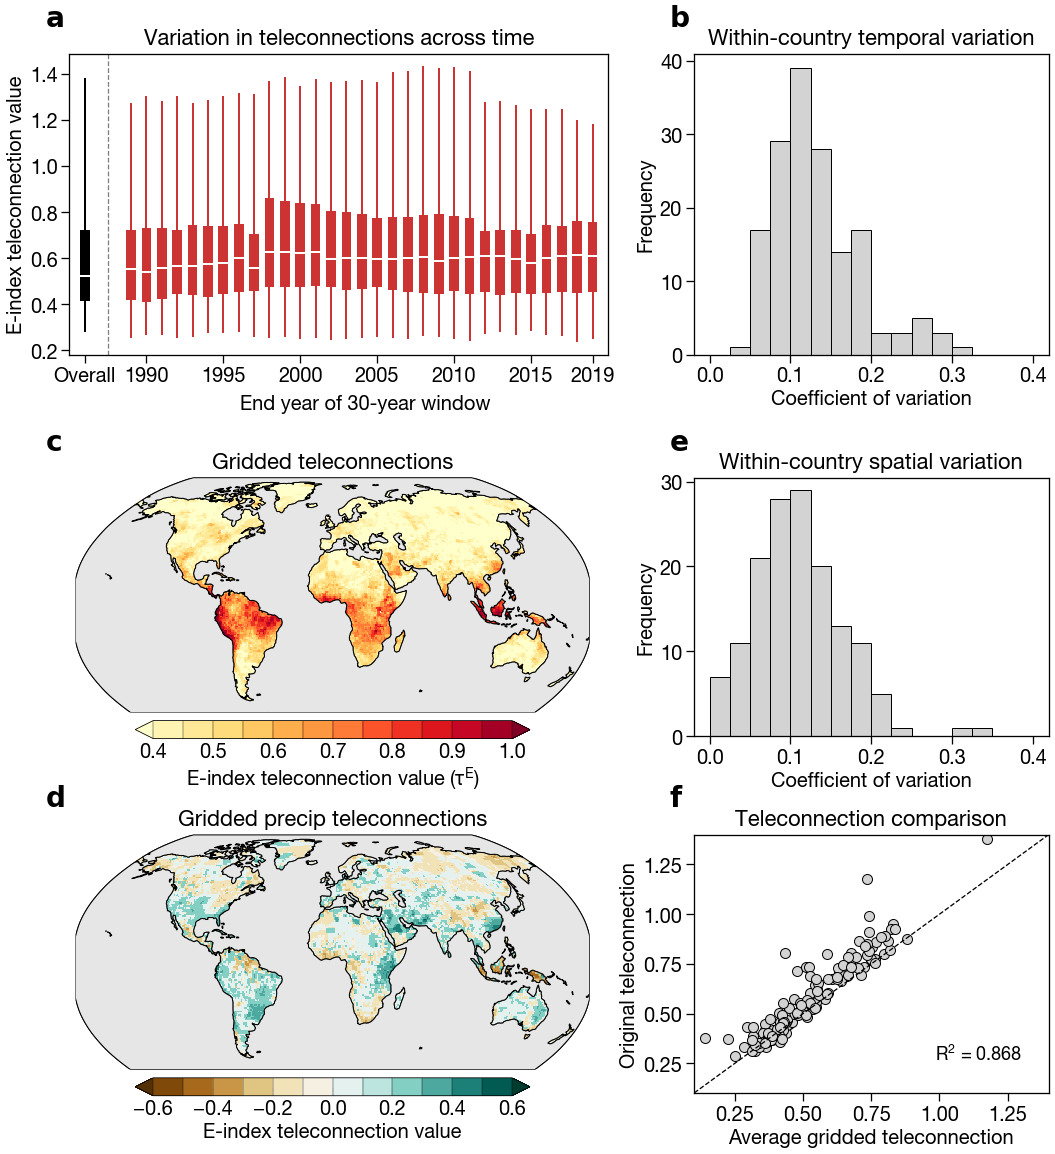

In [18]:
fig = plt.figure(figsize=(17,19))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
#rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 22
lfs = 18

gs0 = gridspec.GridSpec(1,1)
gs0.update(left=0.12,right=0.56,top=0.9,bottom=0.68,wspace=0.25,hspace=0.3)

ax = plt.subplot(gs0[0,0])
plt.setp(ax.spines.values(), linewidth=1.3)


overall_tc = tc_orig[~np.isnan(tc_orig.values)]
b0 = plt.boxplot(overall_tc.values,
               positions=[1986],whis="range",widths=0.5,
               showcaps=False,patch_artist=True)

median_col = "white"
lw = 2
for m in range(0,2,1):
    if m == 0:
        b0["boxes"][m].set(color="black",linewidth=lw)
        b0["medians"][m].set(color="white",linewidth=lw)
    b0["whiskers"][m].set(color="black",linewidth=lw)

y2_window = tc_windows.window.values
for i in np.arange(0,len(y2_window),1):
    window_tc = tc_windows[i,:]
    window_tc_plot = window_tc[~np.isnan(window_tc.values)]
    b1 = plt.boxplot(window_tc_plot.values,
                   positions=[y2_window[i]],whis="range",widths=0.5,
                   showcaps=False,patch_artist=True)

    median_col = "white"
    b_col = [0.8,0.2,0.2]
    lw = 2
    for m in range(0,2,1):
        if m == 0:
            b1["boxes"][m].set(color=b_col,linewidth=lw)
            b1["medians"][m].set(color="white",linewidth=lw)
        b1["whiskers"][m].set(color=b_col,linewidth=lw)
                             
#plt.xlim([0,len(y2_window)+3])
plt.axvline(x=1987.5,color="gray",linestyle="--",linewidth=1.3)
plt.xlim([1985,2020])
plt.xticks(ticks=[1986,1990,1995,2000,2005,2010,2015,2019],
          labels=["Overall","1990","1995","2000","2005","2010","2015","2019"])
plt.xlabel("End year of 30-year window")
ax.xaxis.set_label_coords(0.55,-0.13)

plt.title("Variation in teleconnections across time",fontsize=22,pad=10)
plt.ylabel("E-index teleconnection value")



gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.63,right=0.92,top=0.9,bottom=0.68,wspace=0.25,hspace=0.3)

ax = plt.subplot(gs1[0,0])
plt.setp(ax.spines.values(), linewidth=1.3)

tc_window_cv = tc_windows.std(dim="window")/tc_windows.mean(dim="window")


plt.hist(tc_window_cv[(~np.isnan(tc_window_cv))],
         facecolor="lightgray",edgecolor="black",bins=np.arange(0,0.4+0.025,0.025))
print(np.nanmean(tc_window_cv))
plt.xlabel("Coefficient of variation")
plt.ylabel("Frequency")
plt.title("Within-country temporal variation",fontsize=tfs,pad=10)




## now maps on the left
gs2 = gridspec.GridSpec(2,1)
gs2.update(left=0.12,right=0.55,top=0.59,bottom=0.12,wspace=0.05,hspace=0.25)

# colorbars
shrink = 0.75
asp = 20
pad = 0.03


ax = plt.subplot(gs2[0,0],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
ax.coastlines()


# choose color levels
cmin = 0.4
cmax = 1
nrange = 13
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('YlOrRd')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

# plot
tc_gridded.plot(ax=ax,transform=ccrs.PlateCarree(),
         cmap=cmap,norm=norm,add_colorbar=False)

# add fill
ax.add_feature(cart.feature.OCEAN,zorder=100,edgecolor='black',facecolor=[0.9,0.9,0.9])

# title
plt.title("Gridded teleconnections",pad=10,fontsize=22)


xt = "both"
cb = plt.colorbar(cbar,orientation="horizontal",
                  drawedges=True,extend=xt,
                  shrink=shrink,aspect=asp,pad=pad)
cb.ax.tick_params(direction="in",width=0.05)
cb.set_label("E-index teleconnection value ("+r"$\tau^E$)")



ax = plt.subplot(gs2[1,0],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
ax.coastlines()

# choose color levels
cmin = -0.6
cmax = 0.6
nrange = 13
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('BrBG')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

# plot
p_gridded.plot(ax=ax,transform=ccrs.PlateCarree(),
         cmap=cmap,norm=norm,add_colorbar=False)

# add fill
ax.add_feature(cart.feature.OCEAN,zorder=100,edgecolor='black',facecolor=[0.9,0.9,0.9])

# title
plt.title("Gridded precip teleconnections",pad=10,fontsize=22)


xt = "both"
cb = plt.colorbar(cbar,orientation="horizontal",
                  drawedges=True,extend=xt,
                  shrink=shrink,aspect=asp,pad=pad)
cb.ax.tick_params(direction="in",width=0.05)
cb.set_label("E-index teleconnection value")



## other plots to the right of the map
gs3 = gridspec.GridSpec(2,1)
gs3.update(left=0.63,right=0.92,top=0.59,bottom=0.14,wspace=0.05,hspace=0.38)

# spatial coefficient of variation
ax = plt.subplot(gs3[0,0])
plt.setp(ax.spines.values(), linewidth=1.3)

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.65,right=0.92,top=0.9,bottom=0.68,wspace=0.25,hspace=0.3)

plt.hist(gridded_tc_cv[(~np.isnan(gridded_tc_cv))&(~np.isinf(gridded_tc_cv))&(tc_country_sd!=0)],
         facecolor="lightgray",edgecolor="black",bins=np.arange(0,0.4+0.025,0.025))
print(np.nanmean(gridded_tc_cv[(~np.isnan(gridded_tc_cv))&(~np.isinf(gridded_tc_cv))&(tc_country_sd!=0)]))
plt.xlabel("Coefficient of variation")
plt.ylabel("Frequency")
plt.title("Within-country spatial variation",fontsize=tfs,pad=10)


ax = plt.subplot(gs3[1,0])
plt.setp(ax.spines.values(), linewidth=1.3)

ind = (~np.isnan(tc_country_mean_pw))&(~np.isnan(tc_orig))&(tc_country_mean_pw!=0)
plt.scatter(tc_country_mean_pw[ind],tc_orig[ind],s=100,
           facecolor="lightgray",edgecolor="black")
plt.plot([0,1.8],[0,1.8],linestyle="--",color="black",linewidth=1.3)
plt.xlim([0.1,1.4])
plt.ylim([0.1,1.4])
plt.yticks(np.arange(0.25,1.25+0.25,0.25))
plt.xticks(np.arange(0.25,1.25+0.25,0.25))
plt.title("Teleconnection comparison",fontsize=tfs,pad=10)
plt.xlabel("Average gridded teleconnection")
plt.ylabel("Original teleconnection")
slope, intercept, rvalue, pvalue, se = stats.linregress(tc_country_mean_pw[ind],tc_orig[ind])
r2_value = np.around(rvalue**2,3)
plt.text(0.68,0.13,r"R$^2$ = "+str(r2_value),fontsize=18,
        transform=ax.transAxes)


plt.figtext(0.1,0.92,r'$\bf{a}$',fontsize=28)
plt.figtext(0.61,0.92,r'$\bf{b}$',fontsize=28)

plt.figtext(0.1,0.61,r'$\bf{c}$',fontsize=28)
plt.figtext(0.1,0.35,r'$\bf{d}$',fontsize=28)
plt.figtext(0.61,0.61,r'$\bf{e}$',fontsize=28)
plt.figtext(0.61,0.35,r'$\bf{f}$',fontsize=28)
#plt.figtext(0.11,0.6,r'$\bf{b}$',fontsize=28)

plt.savefig("../Figures/FigX_Teleconnection_Heterogeneity.png")
plt.show()

In [19]:
np.nanmean(gridded_tc_cv[(~np.isnan(gridded_tc_cv))&(~np.isinf(gridded_tc_cv))&(tc_country_sd!=0)])

0.1105155953147546

In [20]:
np.nanmean(tc_window_cv[~np.isnan(tc_window_cv)])

0.13116250390791817

In [21]:
rvalue

0.9316791675496726